# 95-865: Model Validation

Author: George H. Chen (georgechen [at symbol] cmu.edu)

One of the most important things you should get out of this class is how to assess how good different prediction methods are at a particular prediction task. Strangely enough, we do this by solving another prediction problem: for a given method, we predict how well it should do on test data that you don't get access to ahead of time!

For example, for two methods A and B, we can predict their errors on the test set, and whichever one has lower *predicted* error is the one that we choose to use.

Using this same idea, for a method with hyperparameters, we can try various values of the hyperparameter (you can think of it as if we are choosing between, say, 5 different values that the hyperparameter can be, then it's like choosing between 5 methods!). For each hyperparameter setting that we try, we can predict the error the method would have on the test set. Then we go with whichever hyperparameter setting resulted in the lowest *predicted* error.

Note that the *predicted* error might not accurately correspond to the true error on the test set! (For example, I mentioned in lecture that if you're trying to choose between substantially more methods than there are training data, you are very likely to "overfit" the training data, meaning that you will find a method that seems to have an unrealistically low *predicted* error that dramatically underestimates the true error, and you end up choosing a lousy method that does not generalize well to the actual unseen test data!)

---

We begin with some usual boilerplate importing for setting up inline plotting:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# the lines below are just for aesthetics
plt.style.use('ggplot')  # if you want your plot to look at ggplot (like how R makes plots)
%config InlineBackend.figure_format = 'retina'  # if you use a Mac with Retina display

## Data preparation

Next, we load in the MNIST handwritten digit dataset. This dataset consists of 60,000 labeled images to train on (the labels are the true digits the images correspond to, e.g., 0, 1, 2, ..., 9), and 10,000 labeled images to test on. Each image is stored as a 28-by-28 numpy array (correspond to 28-by-28 pixel images), where each value is between 0 and 255 (0 being background, and 255 being foreground, but there are shades in between).

**Warning:** The MNIST dataset neatly specifies what images are training data and which images are test data. In real-world situations, often times you will *not* be told what to use as training vs test data, and you are instead just given a single labeled dataset. In this case, *you* have to decide how to split up the data into train and test. There is no universal one-size-fits-all answer for how to do the splitting. Depending on the kind of data you are working with, it could even be that you only need 1% of the data to use as training data, whereas in many other cases, you might need something more like 70-80% of the data to use as training data.

In [2]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 4s 0us/step


We can check the sizes of the train and test sets:

In [3]:
print(train_images.shape)

(60000, 28, 28)


In [4]:
print(test_images.shape)

(10000, 28, 28)


You can take a look at what an example image looks like:

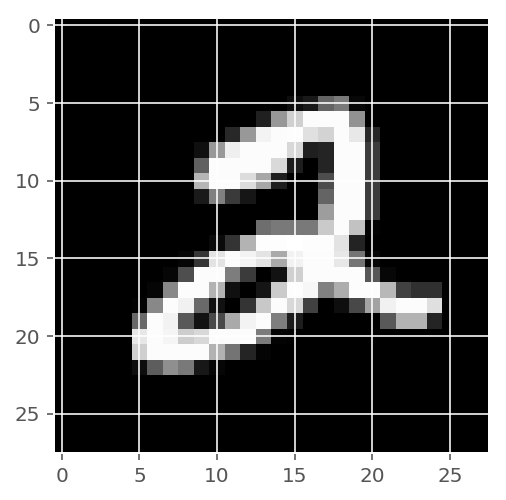

In [5]:
plt.imshow(train_images[5], cmap='gray')

In [6]:
train_labels[5]

2

For simplicity, since the datasets are a little bit for the purposes of this demo, I'm going to take a subsample:

In [7]:
train_images = train_images[:2000]
train_labels = train_labels[:2000]
test_images = test_images[:500]
test_labels = test_labels[:500]

Next, note that each image is stored as a 28-by-28 array of numbers. We want to flatten this out into a single-dimensional array, meaning a row vector that has 28 * 28 = 784 values. We can do this as follows:

In [8]:
flattened_train_images = train_images.reshape(len(train_images), -1)  # flattens out each training image 
#reshape(len(train_images), -1): -1 is numpy's way of saying 
flattened_test_images = test_images.reshape(len(test_images), -1)  # flattens out each test image

Also, we normalize the images so that the values are between 0 and 1 instead of 0 and 255. Many machine learning methods can work better if numbers are close to 0.

In [9]:
flattened_train_images = flattened_train_images.astype(np.float32) / 255  # rescale to be between 0 and 1
flattened_test_images = flattened_test_images.astype(np.float32) / 255  # rescale to be between 0 and 1

In [10]:
print(flattened_train_images.shape)

(2000, 784)


In [11]:
print(flattened_test_images.shape)

(500, 784)


## Prediction

I first show how to use a $C$-SVM classifier using sklearn (I choose $C=1$ for now). For simplicity I fit on all the training data. I then predict on the *training* data (we want to eventually look at the test data, but following good practice when it comes to data, **you should not look at the test data until towards the end of your analysis**).

You can sort of think of this setup as follows: the test set is a take-home exam with an answer key (that you're not supposed to look at, but it's actually there for you, with the idea that you self-grade). The training set is a collection of practice exams with answer keys. You can do whatever you want with the training set to prepare, and to guess how well you will do on the test set, but you should definitely not use anything from the test data to help your preparation! (That would be cheating!)

To use a classifier in sklearn is like everything else in sklearn: you import the class you want to use, create an instance of it (and specify parameters), and then call `fit`, where now when we do the fitting, we have to specify both the feature vectors and their corresponding labels.

In [12]:
from sklearn.svm import SVC
classifier = SVC(C=1)
classifier.fit(flattened_train_images, train_labels)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
predicted_train_labels = classifier.predict(flattened_train_images)

In [14]:
predicted_train_labels

array([5, 0, 4, ..., 5, 2, 0], dtype=uint8)

In [15]:
error_rate = np.mean(predicted_train_labels != train_labels)
print(error_rate)

0.092


## Choosing hyperparameter $C$ using simple data splitting

In the code above, I set $C=1$. How do we choose $C$? The simplest way is to just divide up the training data into a smaller training set and a validation set. Put another way, we're just splitting up the data so that now some of it (namely the validation set) is being treated as "test" data even though it's not actually the test data. We train on the new smaller training set and test on the validation set. We repeat this for different values of $C$ and pick whichever value of $C$ results in the lowest error on the validation set. Effectively we are using the error on the validation set to predict what the error might be for the true test set that we don't get to see!

In [16]:
np.random.seed(95865)  # make randomness deterministic (otherwise re-running the notebook will give different results)
num_train_images = len(flattened_train_images)
shuffled_indices = np.random.permutation(num_train_images)

train_frac = 0.7
smaller_train_indices = shuffled_indices[:int(train_frac*num_train_images)]
validation_indices = shuffled_indices[int(train_frac*num_train_images):]

In [17]:
lowest_error = np.inf
best_C = None
for C in [1e-2, 1e-1, 1, 10, 100, 1000]:
    classifier = SVC(C=C)
    classifier.fit(flattened_train_images[smaller_train_indices],
                   train_labels[smaller_train_indices])
    predicted_val_labels = classifier.predict(flattened_train_images[validation_indices])
    error = np.mean(predicted_val_labels != train_labels[validation_indices])
    print('C:', C, 'error rate:', error)
    
    if error < lowest_error:
        lowest_error = error
        best_C = C

print('Best C:', best_C, 'error rate:', lowest_error)

C: 0.01 error rate: 0.906666666667
C: 0.1 error rate: 0.695
C: 1 error rate: 0.128333333333
C: 10 error rate: 0.0983333333333
C: 100 error rate: 0.105
C: 1000 error rate: 0.103333333333
Best C: 10 error rate: 0.0983333333333


## Choosing hyperparameter $C$ using $k$-fold cross validation

Simple data splitting is easy to do. However, the drawback is that depending on the validation set that is typically randomly chosen, we can get quite different predictions for what the validation error is for each hyperparameter choice. One strategy to combat this is to actually, for each hyperparameter choice, try many different validation sets rather than only 1. A popular way of choosing validation sets so that every training data point gets used at some point within a validation set once is $k$-fold cross validation. Per hyperparameter setting, we now use $k$ different validation sets corresponding to the folds (see lecture slides for how this works).

The drawback of using cross validation compared to data splitting, which is immediately apparent in code, is that it's more expensive: we have another for loop over the cross validation folds, and so the amount of models we need to fit gets multiplied by the number of folds. This can be extremely expensive if model fitting is costly!

In [19]:
from sklearn.model_selection import KFold

lowest_cross_val_error = np.inf
best_C = None

indices = range(num_train_images)
kf = KFold(n_splits=5, shuffle=True, random_state=95865)
for C in [1e-2, 1e-1, 1, 10, 100, 1000]:
    errors = []
    for train_indices, val_indices in kf.split(indices):
        classifier = SVC(C=C)
        classifier.fit(flattened_train_images[train_indices],
                       train_labels[train_indices])
        predicted_val_labels = classifier.predict(flattened_train_images[val_indices])
        error = np.mean(predicted_val_labels != train_labels[val_indices])
        errors.append(error)
        
    cross_val_error = np.mean(errors)
    print('C:', C, 'cross validation error:', cross_val_error)

    if cross_val_error < lowest_cross_val_error:
        lowest_cross_val_error = cross_val_error
        best_C = C

print('Best C:', best_C, 'cross validation error:', lowest_cross_val_error)

C: 0.01 cross validation error: 0.906
C: 0.1 cross validation error: 0.586
C: 1 cross validation error: 0.1165
C: 10 cross validation error: 0.08449999999999999
C: 100 cross validation error: 0.092
C: 1000 cross validation error: 0.09099999999999998
Best C: 10 cross validation error: 0.08449999999999999


## Using different classifiers

The above code works if we swap out the $C$-SVM classifier for a different classifier that has some different hyperparameter(s). For example, see if you can figure out how to use data splitting and 5-fold cross validation to choose the number of trees to use with a random forest. I show below how to train a random forest and then I predict on the training set:

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=95865)  # n_estimators is the number of trees
rf_classifier.fit(flattened_train_images, train_labels)
rf_predicted_train_labels = rf_classifier.predict(flattened_train_images)
rf_error = np.mean(rf_predicted_train_labels != train_labels)
print(rf_error)

0.0


Remarkable: a training error of 0! Of course, this is clearly an overfit.

## Finally actually looking at the test data

Once you've done everything you want to do with the training data (namely trying whatever prediction methods you want to try, and for each one picking the best parameters using, say, cross validation), you can then use each method (with the best parameters from cross validation on training data) to predict on the test data and report the method's  error on the test set. We show how to do this for $C$-SVM using the best value of $C$ determined above:

In [19]:
from sklearn.svm import SVC
final_svm_classifier = SVC(C=best_C)
final_svm_classifier.fit(flattened_train_images, train_labels)
predicted_test_labels = final_svm_classifier.predict(flattened_test_images)
test_set_error = np.mean(predicted_test_labels != test_labels)
print(test_set_error)

0.106


Note that in general the cross validation error is not going to perfectly match up with the test set error.